In [ ]:
# the analyses for the non-Gaussian infos
# initial date: 2024/05/02
# last update: 2024/05/02

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

In [19]:
instrument = 'atms'
channel    = 'ch17'
stdev_from = 'OmF'
#expid      = 'ng_v0'
expid      = 'create_table'
#expid      = 'CTRL'

In [20]:
if expid == 'create_table':
    fn = f'/scratch2/GFDL/gfdlscr/Chih-Chi.Hu/compile_radstats/csv_files/default_used_to_build_pdfs/omf_stats_{instrument}_{channel}.csv'
else:
    fn = f'/scratch2/GFDL/gfdlscr/Chih-Chi.Hu/compile_radstats/csv_files/{expid}/omf_stats_{instrument}_{channel}.csv'
df = pd.read_csv(fn)

#with open(f'/home/Chih-Chi.Hu/python_codes/tables/pkl_files/saved_nginfo_{instrument}_{channel}_{expid}.pkl', 'rb') as f:
with open(f'/home/Chih-Chi.Hu/python_codes/tables/pkl_files/saved_nginfo_{instrument}_{channel}_create_table.pkl', 'rb') as f:
    nginfo = pickle.load(f)

In [ ]:
df.info()
#df.describe()

In [21]:
# screen the data:
dfs = df[abs(df['omf_ges']) < 1e3]

In [22]:
# sort the data based on regions
regions=['land','sea']
lats   =['Global','90S-60S','60S-40S','40S-20S','20S-0','0-20N','20N-40N','40N-60N','60N-90N']

adf={} # "a"nalysis "d"ata "f"rame

for rg in regions:
    adf[rg] = {}  # Initialize the nested dictionary for each experiment
    if rg == 'land':
        dftmp = dfs.loc[ dfs['fland']>=0.99 ]
    elif rg == 'sea':
        dftmp = dfs.loc[ dfs['fwater']>=0.99 ]
        
    for lat in lats:
        if lat == 'Global':
            adf[rg][lat] = dftmp
        elif lat == '90S-60S':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=-60) & (dftmp['lat']>-90) ]
        elif lat == '60S-40S':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=-40) & (dftmp['lat']>-60) ]
        elif lat == '40S-20S':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=-20) & (dftmp['lat']>-40) ]
        elif lat == '20S-0':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=0) & (dftmp['lat']>-20) ]
        elif lat == '0-20N':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=20) & (dftmp['lat']>0) ]
        elif lat == '20N-40N':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=40) & (dftmp['lat']>20) ]
        elif lat == '40N-60N':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=60) & (dftmp['lat']>40) ]
        elif lat == '60N-90N':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=90) & (dftmp['lat']>60) ]

In [ ]:
adf['land']['Global'].describe()

/tmp/ipykernel_2384620/1896720562.py:52: RuntimeWarning: divide by zero encountered in log
  plt.plot(bin_centers, np.log(hist),         linewidth=2, label=f'data')


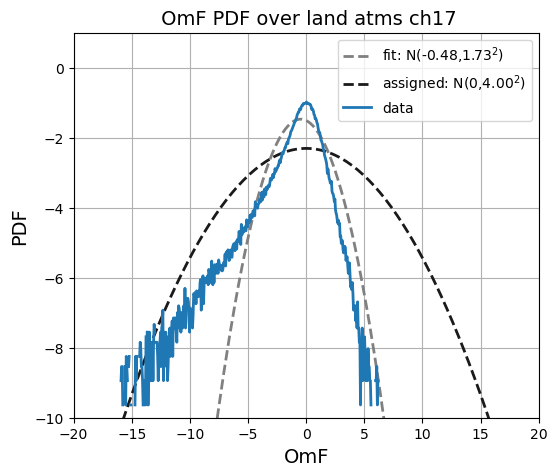

In [23]:
### 
# quick look at the land (might need to dive deeper in the future)
# note that no cloud predictor is defined over the land
### 

# assigned Gaussian "old" errors (for clear-sky)
if instrument == 'amsua':
    if channel == 'ch1':
        assign_std = 3.0
    elif channel == 'ch2':
        assign_std = 2.2
    elif channel == 'ch3':
        assign_std = 2.0
    elif channel == 'ch4':
        assign_std = 0.6
    elif channel == 'ch5':
        assign_std = 0.3
    elif channel == 'ch15':
        assign_std = 3.5
elif instrument == 'atms':
    if channel in ('ch16','ch17'):
        assign_std = 4.0
        

dftmp = adf['land']['Global']

mean_omf  = np.mean(dftmp['omf_ges']) 
stdev_omf = np.std(dftmp['omf_ges'])

### O-B histogram
inflation = 1
q1 = np.percentile(dftmp['omf_ges'], 25)
q3 = np.percentile(dftmp['omf_ges'], 75)
size_omf  = len(dftmp['omf_ges']) 
dx_diag   = 2*(q3-q1)/size_omf**(1/3)
dx_actual = np.ceil(inflation*dx_diag/0.01)*0.01

max_val = (np.ceil(max(dftmp['omf_ges'])/dx_actual)+10)*dx_actual
min_val = (np.floor(min(dftmp['omf_ges'])/dx_actual)-10)*dx_actual
axis_omf = np.arange(min_val, max_val+dx_actual, dx_actual)

fig = plt.figure(figsize=(6,5))
hist, bin_edges = np.histogram(dftmp['omf_ges'], bins=axis_omf, density=True)
bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])

gauss_range = np.linspace(-60,60,500)
hist_gauss_fit = 1/(stdev_omf * np.sqrt(2 * np.pi)) * np.exp( - (gauss_range - mean_omf)**2 / (2 * stdev_omf**2) )
assign_gauss   = 1/(assign_std * np.sqrt(2 * np.pi)) * np.exp( - (gauss_range - 0)**2 / (2 * assign_std**2) )

plt.plot(gauss_range, np.log(hist_gauss_fit), linestyle='--', linewidth=2, color=(0.5,0.5,0.5), label=f'fit: N({mean_omf:.2f},{stdev_omf:.2f}$^2$)')
plt.plot(gauss_range, np.log(assign_gauss), linestyle='--', linewidth=2, color=(0.1,0.1,0.1), label=f'assigned: N(0,{assign_std:.2f}$^2$)')
plt.plot(bin_centers, np.log(hist),         linewidth=2, label=f'data')
plt.grid(True)
'''
if instrument == 'amsua':
    if channel in ('ch1','ch2','ch3'):
        plt.xlim(-8,8)
        plt.ylim(-10,0)       
    if channel == 'ch6':
        plt.xlim(-5,5)
        plt.ylim(-10,1)
'''        
x_range = 5*assign_std 
plt.xlim(-x_range, x_range)
plt.ylim(-10,1)        
plt.xlabel('OmF',fontsize=14)
plt.ylabel('PDF',fontsize=14)
plt.legend()
plt.title(f' OmF PDF over land {instrument} {channel}',fontsize=14)
plt.savefig(f'omf_land_{instrument}_{channel}.png', dpi=200, bbox_inches='tight')

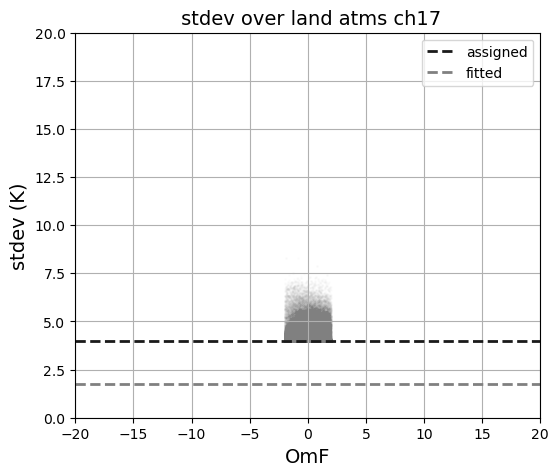

In [24]:
# stdev as a function of omf:
fig = plt.figure(figsize=(6,5))

plt.scatter(dftmp['omf_ges'], 1/dftmp['errinv_ges'], s=1, alpha=0.01, color=(0.5,0.5,0.5))
plt.axhline(y=assign_std, color=(0.1, 0.1, 0.1), linestyle='--', linewidth=2, label='assigned')
plt.axhline(y=stdev_omf,  color=(0.5, 0.5, 0.5), linestyle='--', linewidth=2, label='fitted')

plt.grid(True)
'''
if instrument == 'amsua':
    if channel in ('ch1','ch2','ch3'):
        plt.xlim(-6,6)
        plt.ylim(0,9)
'''
plt.xlim(-x_range, x_range)
plt.ylim(0, x_range)

plt.xlabel('OmF', fontsize=14)
plt.ylabel('stdev (K)', fontsize=14)
plt.legend()
plt.title(f' stdev over land {instrument} {channel}',fontsize=14)
plt.savefig(f'stdev_land_{instrument}_{channel}.png', dpi=200, bbox_inches='tight')

In [25]:
###
# symmetric cloud error bins (cautious! this block runs slow)
###

cloud_range = np.linspace(0,1,51)

clddic={}; # cloud dictionary
for lat in lats:
    print('now processing', lat)
    dftmp = adf['sea'][lat]

    clddic[lat]={}; # initialize the nested dictionary
    
    cld_list=[]; mean_list=[]; stdev_list=[]; ct_list=[];
    for i, c in enumerate(cloud_range[:-1]):
        if np.mod(i,5)==0: 
            print(i)
            
        clddf = dftmp['omf_ges'].loc[ (0.5*(dftmp['clw_obs'] + dftmp['clw_bg_ges'])>= cloud_range[i]  ) & \
                                  (0.5*(dftmp['clw_obs'] + dftmp['clw_bg_ges'])<  cloud_range[i+1]) ]
        cld_list.append(0.5*(cloud_range[i] + cloud_range[i+1]))
        ct_list.append(clddf.shape[0])
        mean_list.append(clddf.mean())
        stdev_list.append(clddf.std())
        
    clddic[lat]['cloud_bin']= cld_list
    clddic[lat]['count']    = ct_list
    clddic[lat]['mean']     = mean_list
    clddic[lat]['stdev']    = stdev_list


now processing Global
0
5
10
15
20
25
30
35
40
45
now processing 90S-60S
0
5
10
15
20
25
30
35
40
45
now processing 60S-40S
0
5
10
15
20
25
30
35
40
45
now processing 40S-20S
0
5
10
15
20
25
30
35
40
45
now processing 20S-0
0
5
10
15
20
25
30
35
40
45
now processing 0-20N
0
5
10
15
20
25
30
35
40
45
now processing 20N-40N
0
5
10
15
20
25
30
35
40
45
now processing 40N-60N
0
5
10
15
20
25
30
35
40
45
now processing 60N-90N
0
5
10
15
20
25
30
35
40
45


In [26]:
# parameters for the piecewise linear fit
if instrument == 'amsua':
    if channel == 'ch1':
        err_params_old = np.array([0.05, 0.60, 2.50, 20.00]) # clear cloud, cloudy cloud, clear stdev, cloudy stdev
        err_params_new = np.array([0.03, 0.35, 2.30,  7.50])
    elif channel == 'ch2':
        err_params_old = np.array([0.03, 0.45, 2.20, 18.00]) # clear cloud, cloudy cloud, clear stdev, cloudy stdev
        err_params_new = np.array([0.03, 0.35, 1.90, 12.00])
    elif channel == 'ch3':
        err_params_old = np.array([0.03, 0.40, 2.00, 12.00]) # clear cloud, cloudy cloud, clear stdev, cloudy stdev
        err_params_new = np.array([0.03, 0.35, 1.50,  7.30]) 
    elif channel == 'ch4':
        err_params_old = np.array([0.02, 0.45, 0.60,  3.00]) # clear cloud, cloudy cloud, clear stdev, cloudy stdev
        err_params_new = np.array([0.03, 0.35, 0.34,  1.22])         
    elif channel == 'ch5':
        err_params_old = np.array([0.00, 1.00, 0.30,  0.50]) # clear cloud, cloudy cloud, clear stdev, cloudy stdev
        err_params_new = np.array([0.03, 0.40, 0.19,  0.38]) 
    elif channel == 'ch15':
        err_params_old = np.array([0.03, 0.20, 3.50, 18.00]) # clear cloud, cloudy cloud, clear stdev, cloudy stdev
        err_params_new = np.array([0.03, 0.25, 3.40,  9.50])         
elif instrument == 'atms':
    if channel == 'ch16':
        err_params_old = np.array([0.02, 0.35, 4.00, 19.00]) # clear cloud, cloudy cloud, clear stdev, cloudy stdev
        err_params_new = np.array([0.03, 0.35, 2.90, 11.00])        
    elif channel == 'ch17':
        err_params_old = np.array([0.03, 0.50, 4.00, 30.00]) # clear cloud, cloudy cloud, clear stdev, cloudy stdev
        err_params_new = np.array([0.03, 0.30, 1.50,  5.30])    
        
        
# construct the piecewise linear model:
num_cloud_bin = len(clddic[lat]['cloud_bin'])
err_model_old = np.zeros(num_cloud_bin)
err_model_new = np.zeros(num_cloud_bin)
for i in range(num_cloud_bin):
    if cloud_range[i] < err_params_old[0]:
        err_model_old[i] = err_params_old[2]
    elif (cloud_range[i] >= err_params_old[0]) & (cloud_range[i] < err_params_old[1]):
        err_model_old[i] = np.interp(cloud_range[i], np.array(err_params_old[0:2]), np.array(err_params_old[2:]))
    elif cloud_range[i] >= err_params_old[1]:
        err_model_old[i] = err_params_old[3]

for i in range(num_cloud_bin):        
    if cloud_range[i] < err_params_new[0]:
        err_model_new[i] = err_params_new[2]
    elif (cloud_range[i] >= err_params_new[0]) & (cloud_range[i] < err_params_new[1]):
        err_model_new[i] = np.interp(cloud_range[i], np.array(err_params_new[0:2]), np.array(err_params_new[2:]))
    elif cloud_range[i] >= err_params_new[1]:
        err_model_new[i] = err_params_new[3]

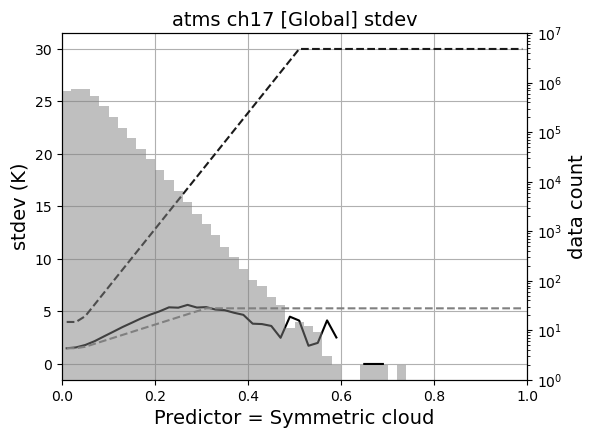

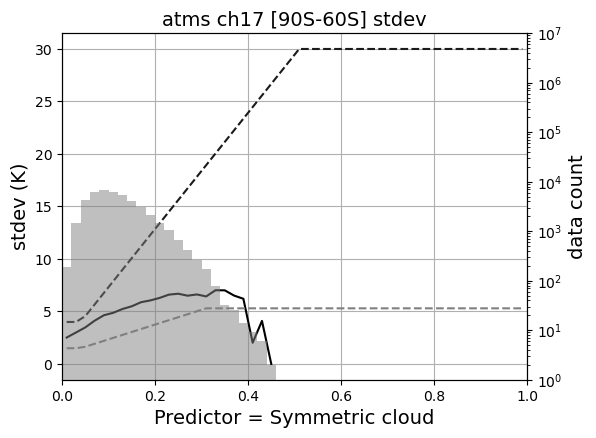

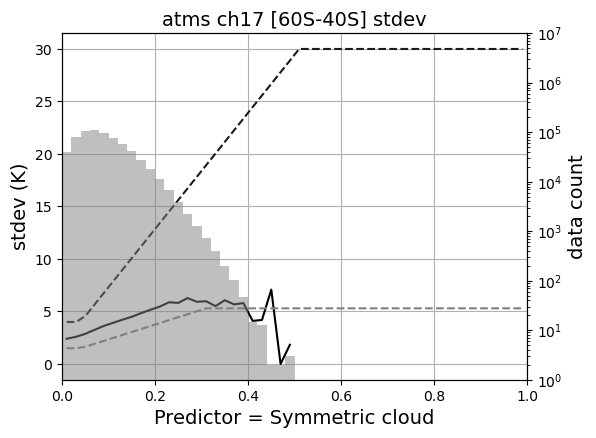

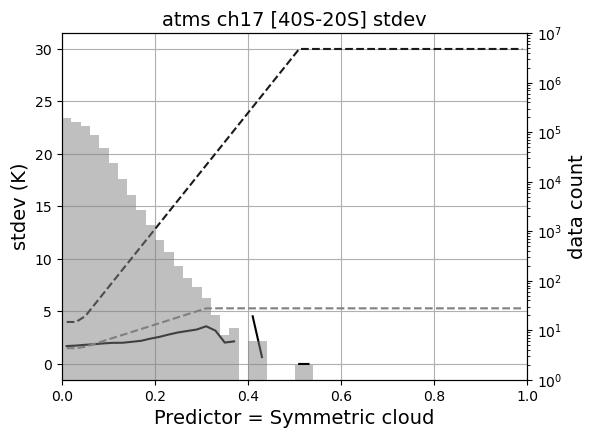

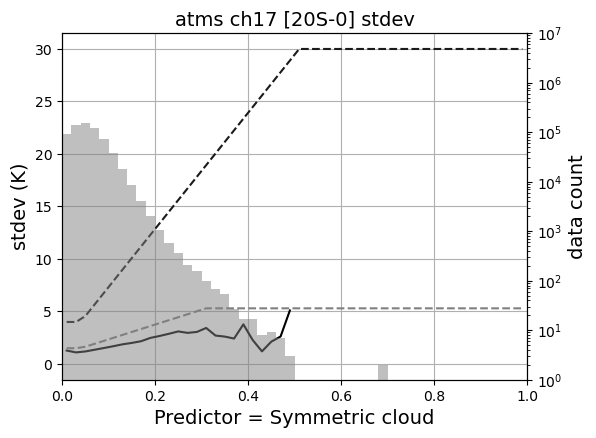

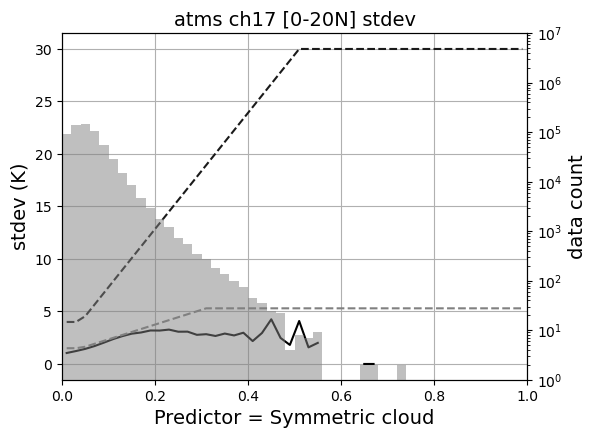

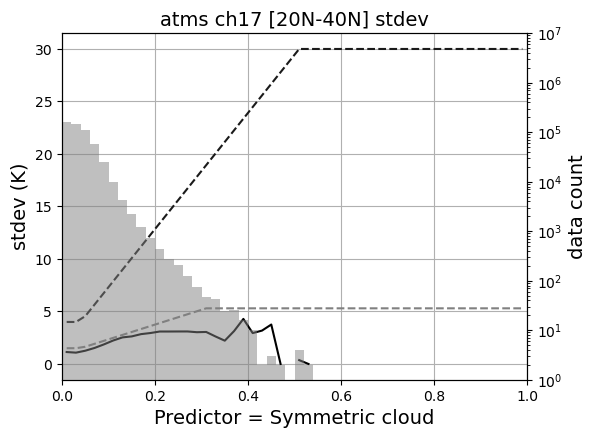

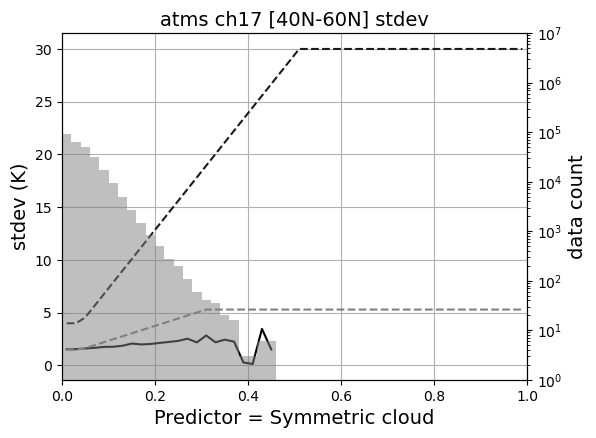

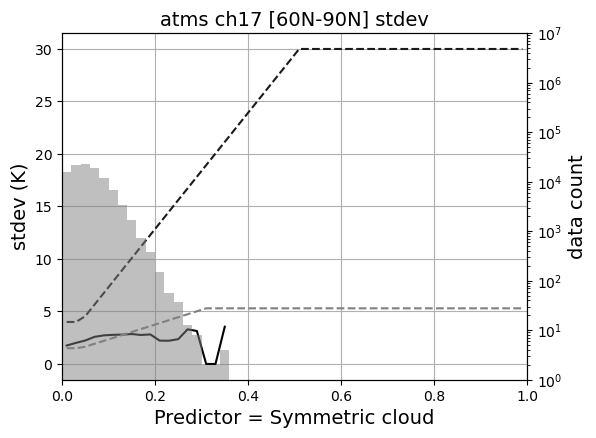

In [27]:
# plot the stdev errors/data counts

for lat in lats:
    fig, ax1 = plt.subplots(figsize=(6,4.5))
    
    ax1.plot(clddic[lat]['cloud_bin'], clddic[lat]['stdev'], color=(0,0,0))
    ax1.plot(clddic[lat]['cloud_bin'], err_model_old, color=(0.1, 0.1, 0.1), linestyle='--')
    ax1.plot(clddic[lat]['cloud_bin'], err_model_new, color=(0.5, 0.5, 0.5), linestyle='--')

    ax1.set_xlabel('Predictor = Symmetric cloud', fontsize=14)
    ax1.set_ylabel('stdev (K)', fontsize=14)
    ax1.set_xlim(0,1)
    if instrument == 'amsua':
        if channel == ('ch1'):
            ax1.set_ylim(0,25)
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.bar(clddic[lat]['cloud_bin'], clddic[lat]['count'], width=0.02, color=(0.5, 0.5, 0.5), alpha=0.5)
    ax2.set_yscale('log')
    ax2.set_ylim(1,1e7)
    ax2.set_ylabel('data count', fontsize=14)

    ax1.set_title(f'{instrument} {channel} [{lat}] stdev', fontsize=14)
    plt.savefig(f'omf_stdev_sea_symcloud_{instrument}_{channel}_{lat}.png', dpi=200, bbox_inches='tight')

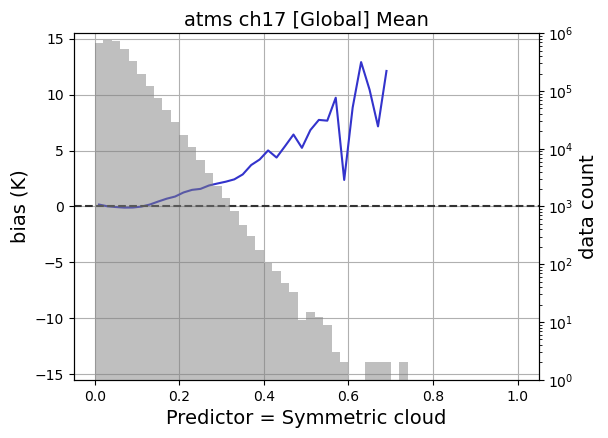

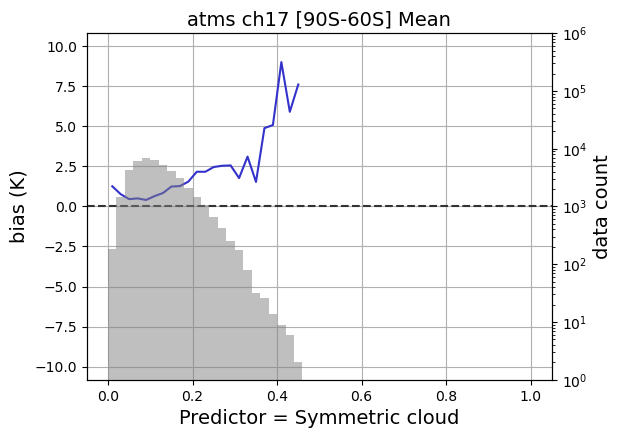

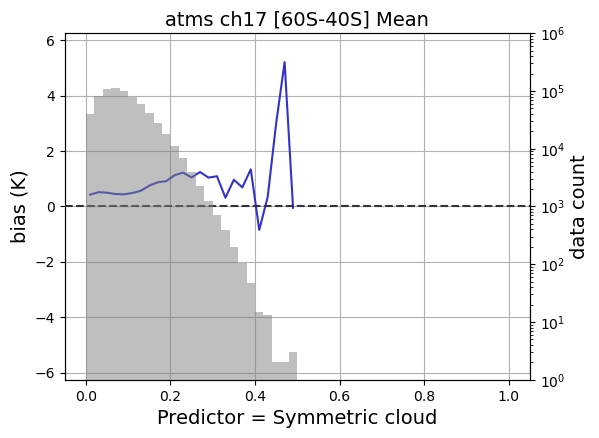

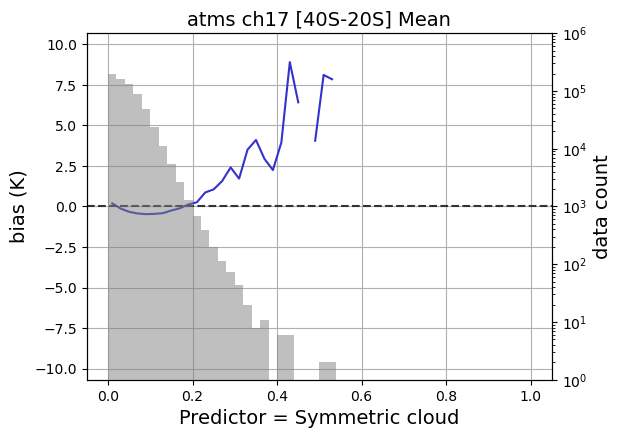

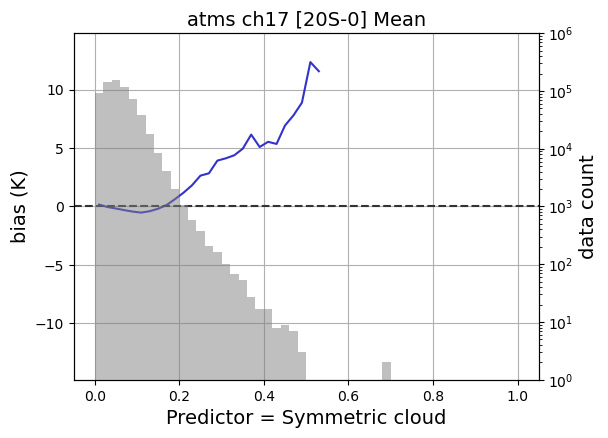

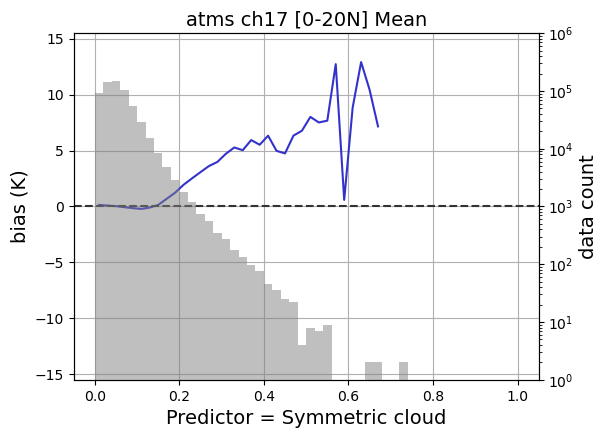

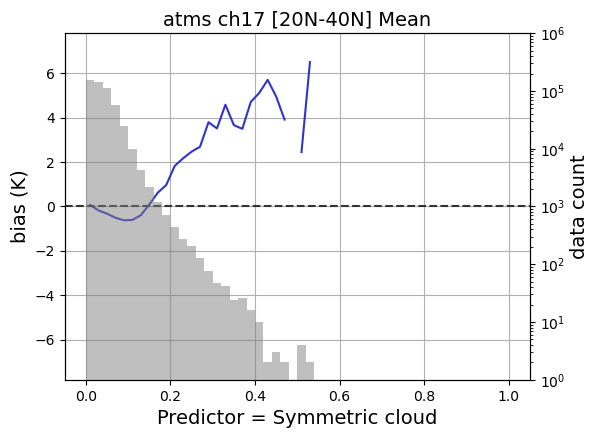

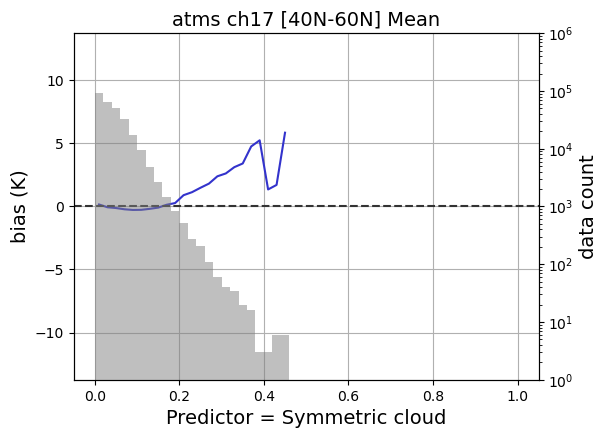

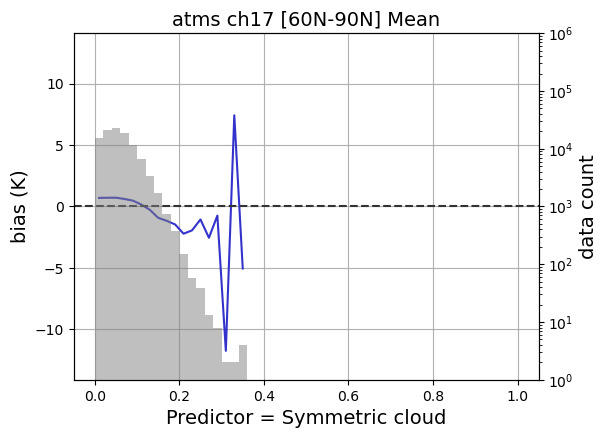

In [28]:
# plot the biases (optional?)
for lat in lats:
    fig, ax1 = plt.subplots(figsize=(6,4.5))

    ax1.plot(clddic[lat]['cloud_bin'], clddic[lat]['mean'], color=(0.2,0.2,0.8))
    ax1.axhline(y=0, color=(0.2,0.2,0.2), linestyle='--')
    ax1.set_xlabel('Predictor = Symmetric cloud', fontsize=14)
    ax1.set_ylabel('bias (K)', fontsize=14)
    plot_range = 1.2*max(np.abs(clddic[lat]['mean']))
    ax1.set_ylim(-plot_range, plot_range)
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.bar(clddic[lat]['cloud_bin'], clddic[lat]['count'], width=0.02, color=(0.5, 0.5, 0.5), alpha=0.5)
    ax2.set_yscale('log')
    ax2.set_ylim(1,1e6)
    ax2.set_ylabel('data count', fontsize=14)

    ax1.set_title(f'{instrument} {channel} [{lat}] Mean', fontsize=14)
    plt.savefig(f'omf_mean_sea_symcloud_{instrument}_{channel}_{lat}.png', dpi=200, bbox_inches='tight')

In [29]:
###
# evaluate the joint pdf between symcloud and omf for different latitude (could be slow...)
###
counts={}; 
for lat in lats:
    print(f'processing {lat}...')
    x = 0.5*(adf['sea'][lat]['clw_obs'] + adf['sea'][lat]['clw_bg_ges']) 
    y = adf['sea'][lat]['omf_ges']

    xedges = np.linspace(0,1,41)
    if instrument == 'amsua':
        if channel in ('ch1','ch2','ch3','ch15'):
            yedges = np.linspace(-40,40,41)
        elif channel in ('ch4'):
            yedges = np.linspace(-10,10,41)
        elif channel in ('ch5'):
            yedges = np.linspace(-5,5,41)
    elif instrument == 'atms':
        if channel in ('ch16','ch17'):
            yedges = np.linspace(-40,40,41)
            
            
    
    counts[lat], _, _ = np.histogram2d(x, y, bins=[xedges, yedges])


processing Global...
processing 90S-60S...
processing 60S-40S...
processing 40S-20S...
processing 20S-0...
processing 0-20N...
processing 20N-40N...
processing 40N-60N...
processing 60N-90N...


/tmp/ipykernel_2384620/889609331.py:9: RuntimeWarning: divide by zero encountered in log
  plt.contourf(xx, yy, np.log(counts[lat]).transpose(), cmap='inferno')


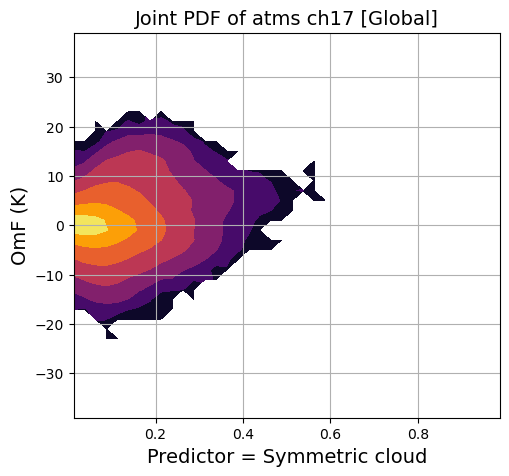

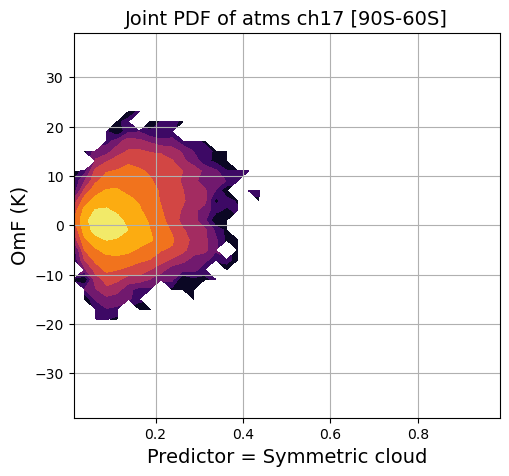

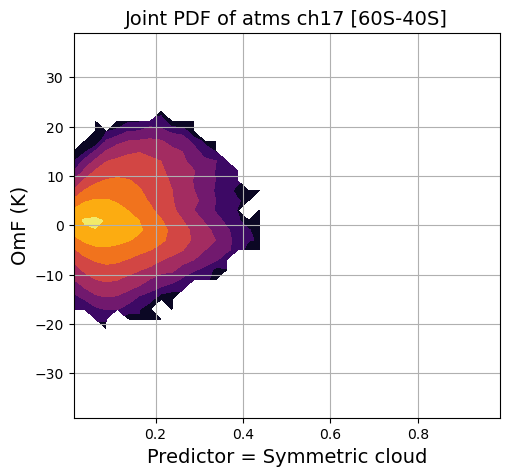

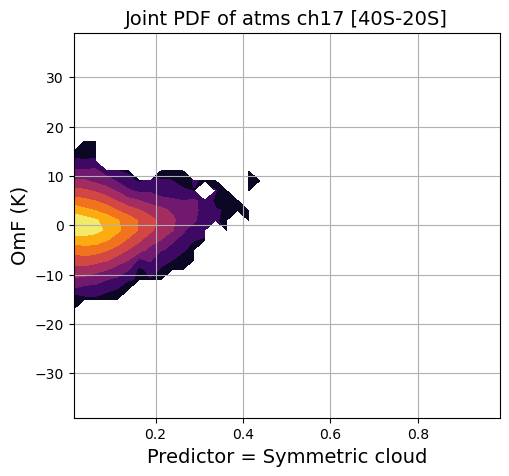

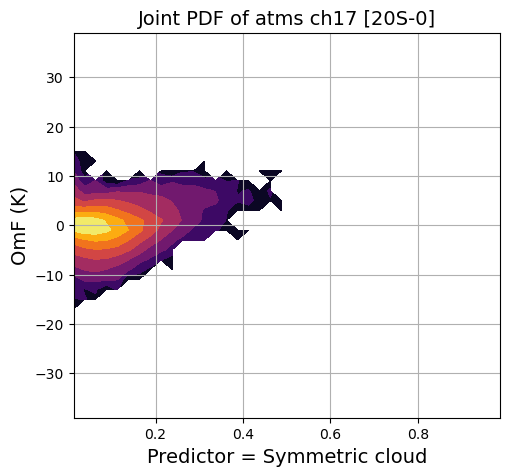

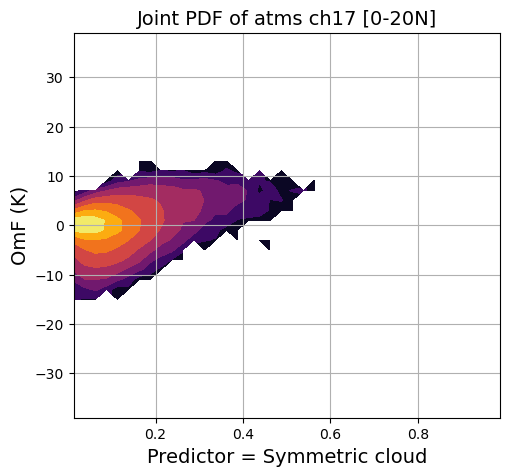

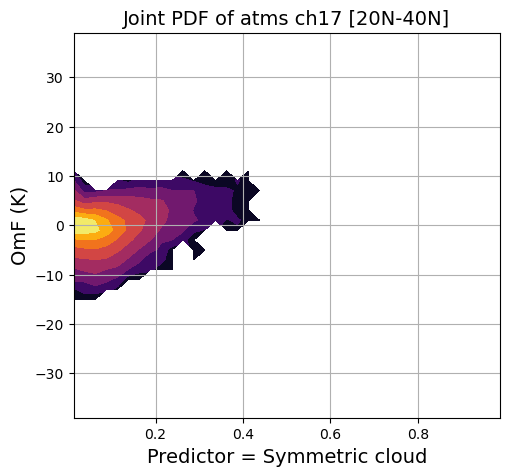

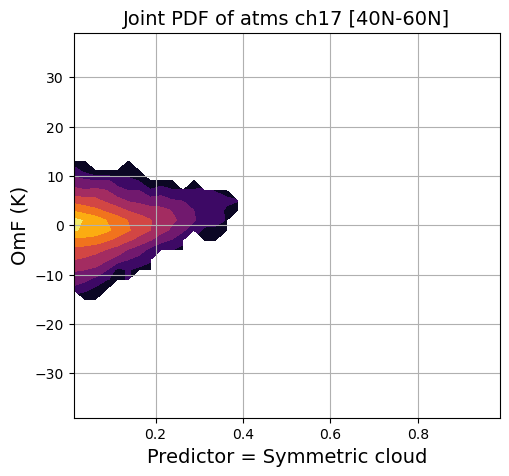

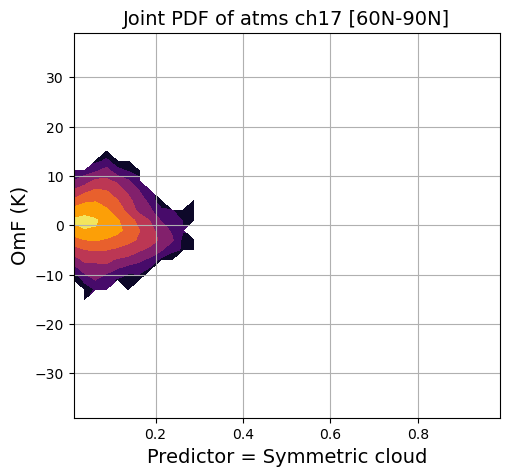

In [30]:
# plot the joint PDFs
xbins = 0.5*(xedges[:-1] + xedges[1:])
ybins = 0.5*(yedges[:-1] + yedges[1:])

xx,yy = np.meshgrid(xbins, ybins)

for lat in lats:
    fig, ax1 = plt.subplots(figsize=(5.5,5))
    plt.contourf(xx, yy, np.log(counts[lat]).transpose(), cmap='inferno')
    plt.grid(True)
    plt.xlabel('Predictor = Symmetric cloud', fontsize=14)
    plt.ylabel('OmF (K)', fontsize=14)
    plt.title(f'Joint PDF of {instrument} {channel} [{lat}]', fontsize=14)
    plt.savefig(f'omf_jointpdf_sea_symcloud_{instrument}_{channel}_{lat}.png', dpi=200, bbox_inches='tight')

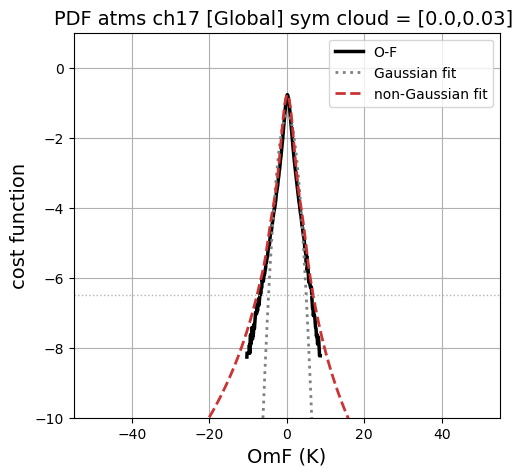

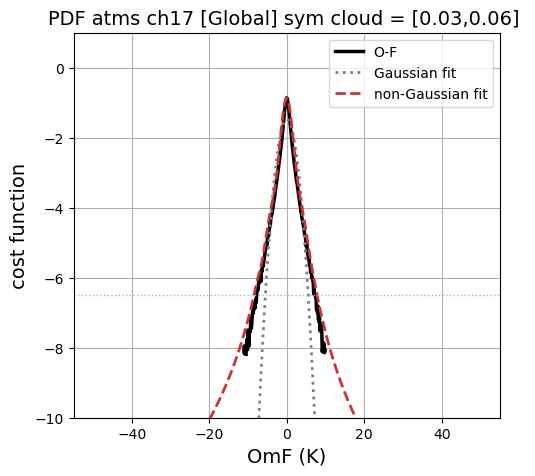

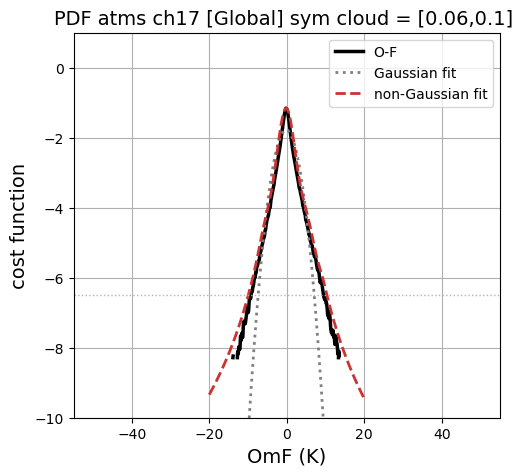

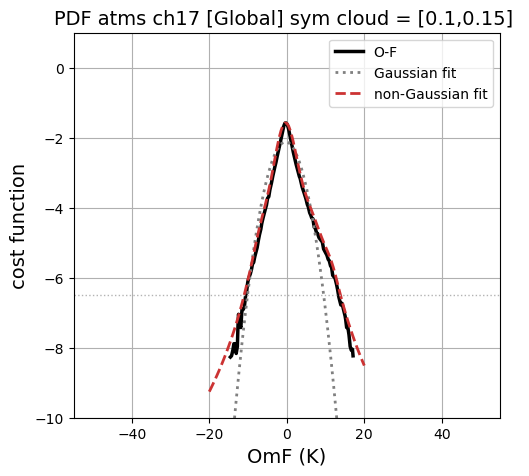

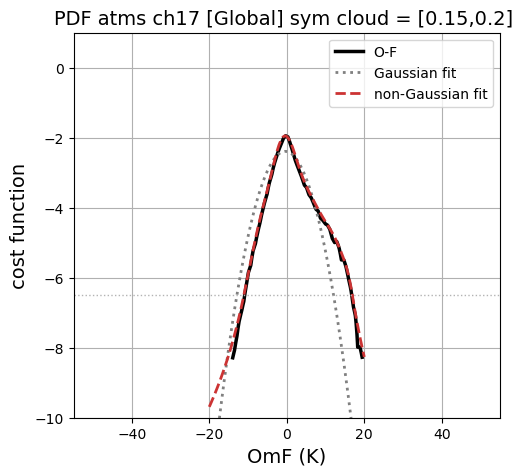

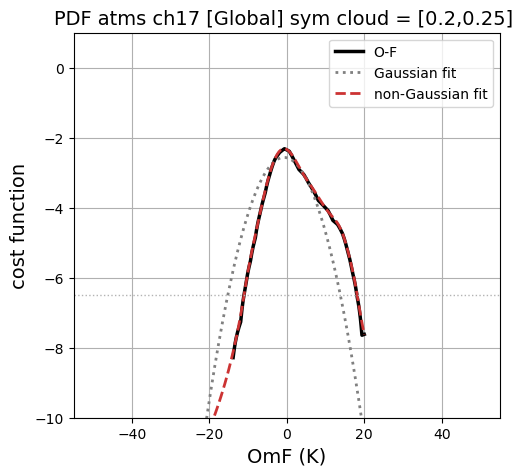

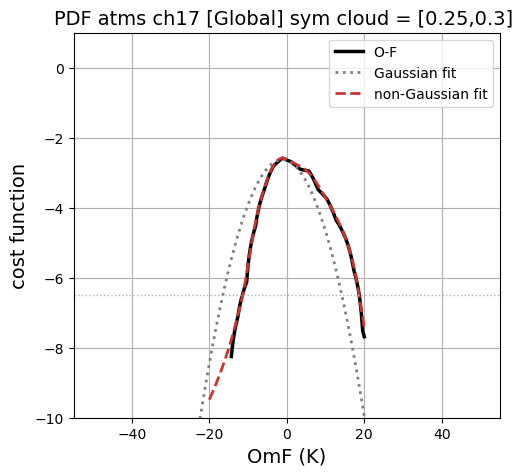

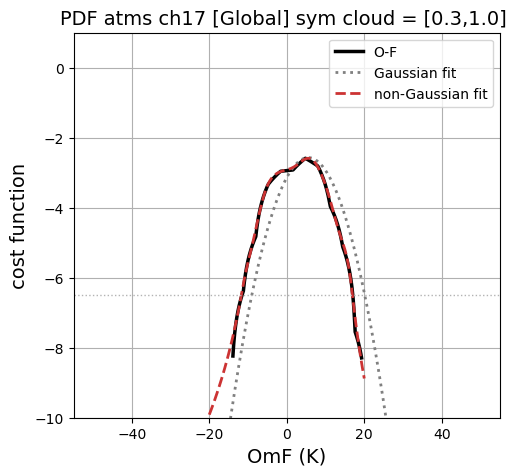

In [31]:
### Plot the non-Gaussian table info
# plot the marginal pdf + Gaussian approx + NG table approx

lats=['Global']

n_cat = len(nginfo) # the number of cloud category

for lat in lats:
    for i in range(n_cat):
        # Gaussian approx:
        gauss_range = np.linspace(-50,50,501)
        hist_gauss_fit = 1/(nginfo[i]['stdev'] * np.sqrt(2 * np.pi)) * np.exp( - (gauss_range - nginfo[i]['mode'])**2 / (2 * nginfo[i]['stdev']**2) )
        
        fig, ax1 = plt.subplots(figsize=(5.5,5))
        ax1.plot(nginfo[i]['axis_omf'], -nginfo[i]['cost_fn'], color='black', linewidth=2.5, label=f'O-F')
        ax1.plot(gauss_range, np.log(hist_gauss_fit), linestyle=':', linewidth=2, color=(0.5,0.5,0.5), label=f'Gaussian fit')
        ax1.plot(nginfo[i]['coarse_axis'], -nginfo[i]['recon_cost'], linestyle='--', linewidth=2, color=(0.8,0.2,0.2), label='non-Gaussian fit')
        ax1.axhline(y=-nginfo[i]['critical_cost_val'], linestyle=':', linewidth=1, color=(0.7,0.7,0.7))

        ax1.grid(True)
        ax1.set_xlabel('OmF (K)', fontsize=14)
        ax1.set_ylabel('cost function', fontsize=14)
        if instrument == 'amsua':
            if channel in ('ch1','ch2','ch3','ch15'):
                ax1.set_xlim(-50,50)
            elif channel in ('ch4'):
                ax1.set_xlim(-8,8)
            elif channel in ('ch5'):
                ax1.set_xlim(-5,5)
        ax1.set_ylim(-10,1)
        ax1.legend()
        cld_edge1 = nginfo[i]['cloud_edge'][0] 
        cld_edge2 = nginfo[i]['cloud_edge'][1]
        ax1.set_title(f'PDF {instrument} {channel} [{lat}] sym cloud = [{cld_edge1},{cld_edge2}] ', fontsize=14)
        
        plt.savefig(f'omf_marginal_pdf_sea_symcloud_{cld_edge1}_{cld_edge2}_{instrument}_{channel}_{lat}.png', dpi=200, bbox_inches='tight')

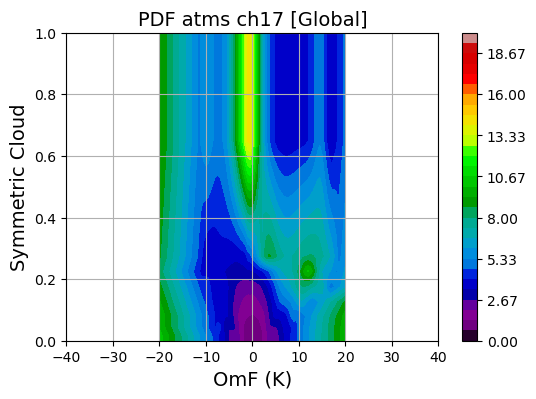

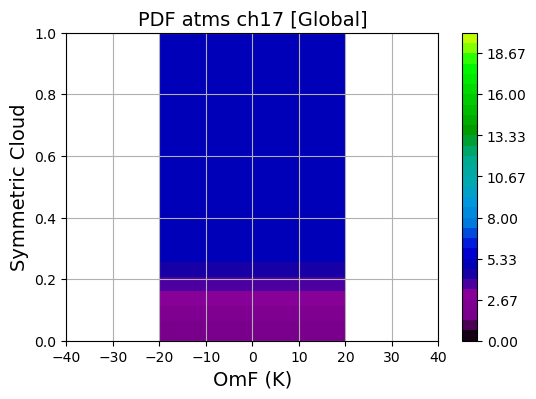

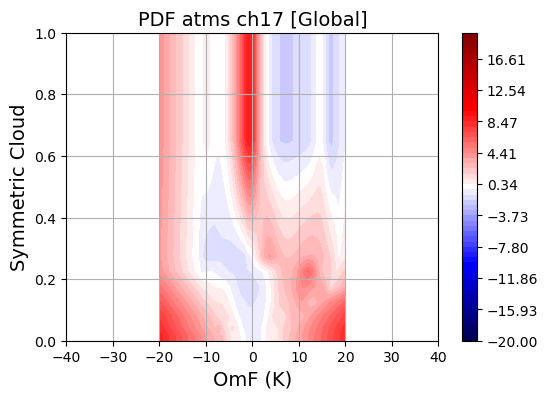

In [32]:
# plot the stdev as a function of cloud & OmF

lats=['Global']

n_cat = len(nginfo) # the number of cloud category

cloud_edge = np.zeros(n_cat+2)
sig_map    = np.zeros((n_cat+2, len(nginfo[0]['coarse_axis'])))
cloud_edge[0] = 0
sig_map[0][:] = nginfo[0]['coarse_record_sig'][:]
for i in range(n_cat):
    cloud_edge[i+1] = nginfo[i]['cloud_edge'][0]
    sig_map[i+1][:] = nginfo[i]['coarse_record_sig'][:]
cloud_edge[n_cat+1] = nginfo[n_cat-1]['cloud_edge'][1]
sig_map[n_cat+1][:] = nginfo[n_cat-1]['coarse_record_sig'][:]

x_omf   = nginfo[i]['coarse_axis']
y_cloud = np.hstack((0.5*(cloud_edge[:-1] + cloud_edge[1:]), cloud_edge[-1]))

# construct the piecewise linear model:
sig_gauss = np.zeros(n_cat+2)

sig_gauss[0] = err_params_new[2]
for i in range(n_cat+2):      
    if y_cloud[i] < err_params_new[0]:
        sig_gauss[i] = err_params_new[2]
    elif (y_cloud[i] >= err_params_new[0]) & (y_cloud[i] < err_params_new[1]):
        sig_gauss[i] = np.interp(y_cloud[i], np.array(err_params_new[0:2]), np.array(err_params_new[2:]))
    elif y_cloud[i] >= err_params_new[1]:
        sig_gauss[i] = err_params_new[3]

sig_gauss_map = np.tile(sig_gauss, (len(nginfo[0]['coarse_axis']),1)).transpose()

if instrument == 'amsua':
    if channel in ('ch1','ch2','ch3','ch15'):
        cbar_range = 30
    elif channel in ('ch4'):
        cbar_range = 3
    elif channel in ('ch5'):
        cbar_range = 1.5
elif instrument == 'atms':
    if channel in ('ch16','ch17'):
        cbar_range = 20


for lat in lats:
    xx, yy = np.meshgrid(x_omf, y_cloud)
        
    fig, ax1 = plt.subplots(figsize=(6,4))
    cntr=ax1.contourf(xx,yy,sig_map, cmap='nipy_spectral', levels=np.linspace(0,cbar_range,31), vmin=0, vmax=cbar_range)
    cbar=plt.colorbar(cntr,ax=ax1)
    ax1.grid(True)
    ax1.set_xlabel('OmF (K)', fontsize=14)
    ax1.set_ylabel('Symmetric Cloud', fontsize=14)
    if instrument == 'amsua':
        if channel == 'ch1':
            ax1.set_xlim(-50,50)
    ax1.set_xlim(-2*x_range, 2*x_range)
    ax1.set_ylim(0,1)
    ax1.set_title(f'PDF {instrument} {channel} [{lat}]', fontsize=14)
    plt.savefig(f'ng_table_{instrument}_{channel}_{lat}.png', dpi=200, bbox_inches='tight')
    
    
    
    fig, ax2 = plt.subplots(figsize=(6,4))
    cntr=ax2.contourf(xx,yy,sig_gauss_map, cmap='nipy_spectral', levels=np.linspace(0,cbar_range,31), vmin=0, vmax=30)
    cbar=plt.colorbar(cntr,ax=ax2)
    ax2.grid(True)
    ax2.set_xlabel('OmF (K)', fontsize=14)
    ax2.set_ylabel('Symmetric Cloud', fontsize=14)
    if instrument == 'amsua':
        if channel == 'ch1':
            ax2.set_xlim(-50,50)
    ax2.set_xlim(-2*x_range, 2*x_range)
    ax2.set_ylim(0,1)
    ax2.set_title(f'PDF {instrument} {channel} [{lat}]', fontsize=14)
    plt.savefig(f'g_table_{instrument}_{channel}_{lat}.png', dpi=200, bbox_inches='tight')
    
    
    
    fig, ax3 = plt.subplots(figsize=(6,4))
    cntr=ax3.contourf(xx,yy,sig_map-sig_gauss_map, cmap='seismic', levels=np.linspace(-cbar_range,cbar_range,60), vmin=-cbar_range, vmax=cbar_range)
    cbar=plt.colorbar(cntr,ax=ax3)
    ax3.grid(True)
    ax3.set_xlabel('OmF (K)', fontsize=14)
    ax3.set_ylabel('Symmetric Cloud', fontsize=14)
    if instrument == 'amsua':
        if channel == 'ch1':
            ax3.set_xlim(-50,50)
    ax3.set_xlim(-2*x_range, 2*x_range)
    ax3.set_ylim(0,1)
    ax3.set_title(f'PDF {instrument} {channel} [{lat}]', fontsize=14)
    plt.savefig(f'ng_g_table_diff_{instrument}_{channel}_{lat}.png', dpi=200, bbox_inches='tight')


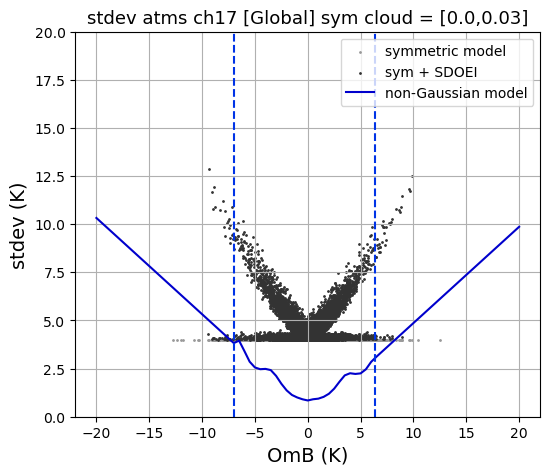

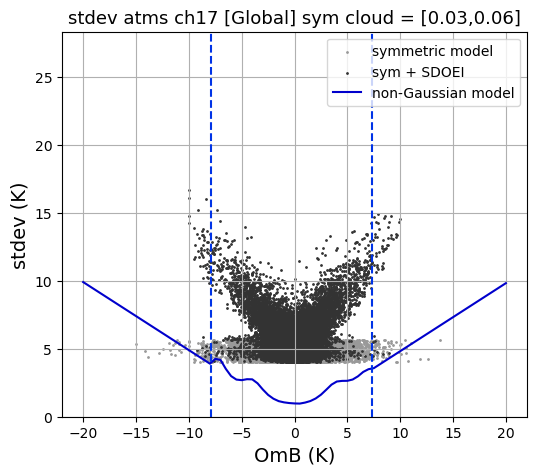

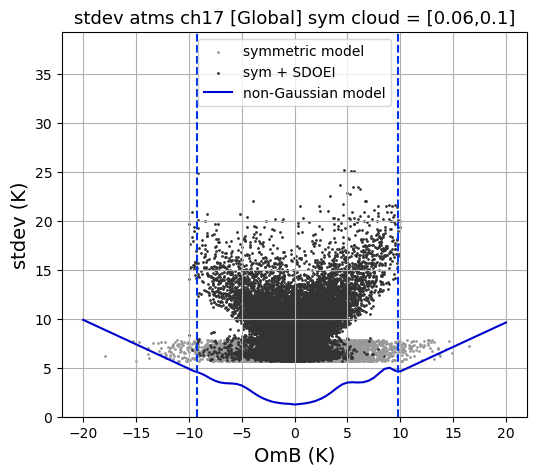

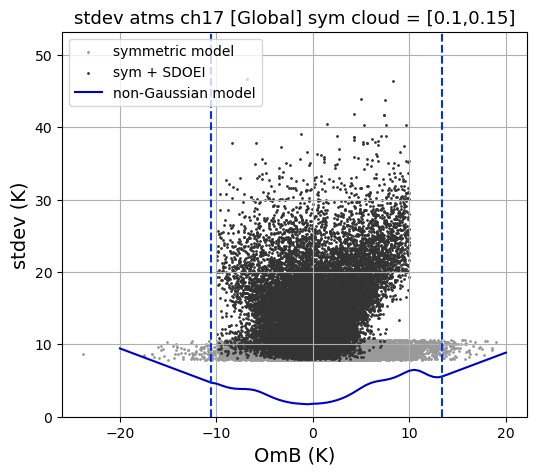

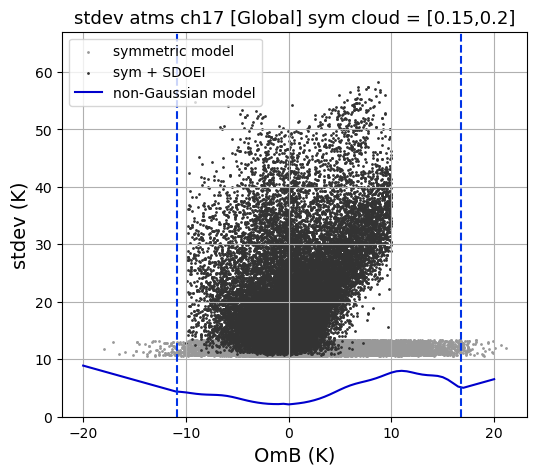

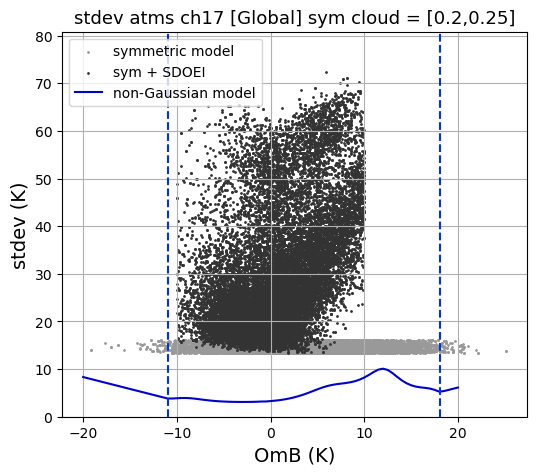

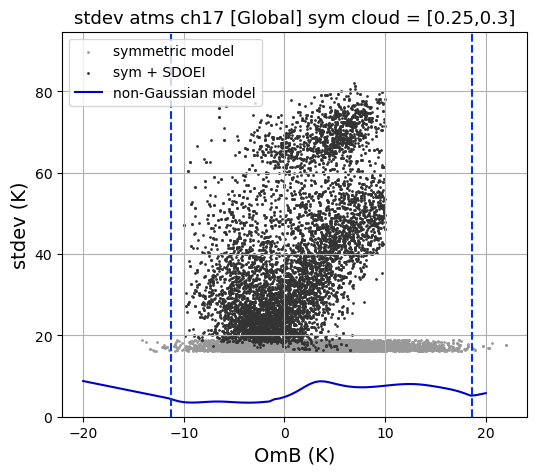

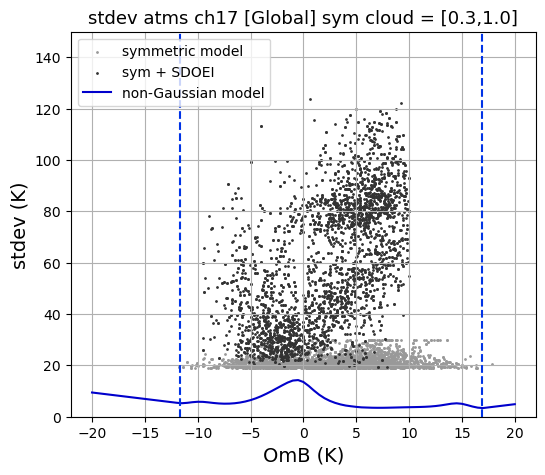

In [33]:
# compare the symmetric Gaussian error/non-Gaussian error/ SDOEI
import random
# create the dataframe for a selected range of symmetric cloud amount:
tmpdf  = adf['sea']['Global']
for i in range(len(nginfo)):
    select_cloud_df = tmpdf.loc[ ( 0.5*(tmpdf['clw_obs'] + tmpdf['clw_bg_ges']) >= nginfo[i]['cloud_edge'][0] )& \
                                 ( 0.5*(tmpdf['clw_obs'] + tmpdf['clw_bg_ges']) <  nginfo[i]['cloud_edge'][1] )] 

    symerr = select_cloud_df['symerr_ges']
    inferr = 1/select_cloud_df['errinv_ges']
    n_data = len(select_cloud_df)
    plot_data = random.sample(range(1, n_data), min(30000,n_data-1))
    
    fig, ax = plt.subplots(figsize=(6,5))
    ax.scatter(select_cloud_df['omf_ges'].iloc[plot_data],   select_cloud_df['symerr_ges'].iloc[plot_data], s=1, color=(0.6,0.6,0.6), label='symmetric model')
    ax.scatter(select_cloud_df['omf_ges'].iloc[plot_data], 1/select_cloud_df['errinv_ges'].iloc[plot_data], s=1, color=(0.2,0.2,0.2), label='sym + SDOEI')
    ax.plot(nginfo[i]['coarse_axis'], nginfo[i]['coarse_record_sig'], linewidth=1.5, color=(0, 0, 0.8), label='non-Gaussian model')
    ax.axvline(nginfo[i]['axis_omf'][nginfo[i]['range_min_idx']], linestyle='--', color=(0, 0.2, 0.9))
    ax.axvline(nginfo[i]['axis_omf'][nginfo[i]['range_max_idx']], linestyle='--', color=(0, 0.2, 0.9))
    #plt_range = max(np.abs(select_cloud_df.loc[(select_cloud_df['qcmark']==0)]['omf_ges']))
    #ax.set_xlim(-1.2*plt_range, 1.2*plt_range)
    ax.set_ylim(0, 5*max(select_cloud_df['symerr_ges'].iloc[plot_data]))
    ax.set_xlabel('OmB (K)',fontsize=14)
    ax.set_ylabel('stdev (K)',fontsize=14)
    ax.legend(loc='best')
    sym_cloud_low  = nginfo[i]['cloud_edge'][0] 
    sym_cloud_high = nginfo[i]['cloud_edge'][1]
    ax.set_title(f'stdev {instrument} {channel} [Global] sym cloud = [{sym_cloud_low},{sym_cloud_high}]',fontsize=13)
    plt.grid(True)
    
    plt.savefig(f'stdev_{instrument}_{channel}_global_{sym_cloud_low}_{sym_cloud_high}.png', dpi=200, bbox_inches='tight')


In [8]:
select_cloud_df = tmpdf.loc[ ( 0.5*(tmpdf['clw_obs'] + tmpdf['clw_bg_ges']) >= nginfo[0]['cloud_edge'][0] )& \
                             ( 0.5*(tmpdf['clw_obs'] + tmpdf['clw_bg_ges']) <  nginfo[0]['cloud_edge'][1] )] 

np.sqrt(1/select_cloud_df['errinv_ges'])

74         1.692088
83         1.682207
100        1.737406
109        1.738028
117        1.840060
             ...   
3180451    1.673049
3180452    1.657050
3180453    1.653206
3180457    1.660835
3180458    1.626558
Name: errinv_ges, Length: 547297, dtype: float64

In [10]:
select_cloud_df

,sensor,lat,lon,fwater,fland,obs,clw_obs,clw_bg_ges,symerr_ges,errinv_ges,omf_ges,clw_bg_anl,symerr_anl,errinv_anl,omf_anl
74,n15,-29.4318,94.1156,1.0,0.0,178.22,0.001459,0.040584,1.826869,0.349264,-1.391301,0.023878,1.825355,0.349272,-1.290349
83,n15,-27.5491,94.4900,1.0,0.0,181.63,0.025930,0.031029,1.810790,0.353379,-0.319320,0.021585,1.812553,0.000000,-0.436845
100,n15,-25.6661,94.8639,1.0,0.0,175.87,0.000000,0.000000,1.987950,0.331282,-2.689307,0.000000,1.933023,0.334445,-2.310501
109,n15,-24.2537,95.1443,1.0,0.0,179.86,0.001561,0.044409,2.064882,0.331044,-3.219875,0.031947,1.917559,0.340373,-2.203855
117,n15,-22.5463,92.6439,1.0,0.0,170.23,0.000000,0.059223,2.446238,0.295349,-4.831085,0.034644,1.964852,0.324771,-2.530015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3180451,n18,59.4266,348.2095,1.0,0.0,174.32,0.028685,0.025656,1.806479,0.357259,-0.031899,0.025091,1.806069,0.357427,-0.004577
3180452,n18,59.2056,351.0233,1.0,0.0,179.90,0.008621,0.017757,1.838684,0.364191,0.915789,0.017203,1.800439,0.368386,0.405849
3180453,n18,59.3189,352.5736,1.0,0.0,182.50,0.004809,0.016608,1.944259,0.365886,-2.387996,0.013849,1.820163,0.374689,-0.944208
3180457,n18,60.5919,350.5360,1.0,0.0,181.77,0.017777,0.021687,1.866409,0.362533,1.285451,0.027309,1.803877,0.370409,0.141517


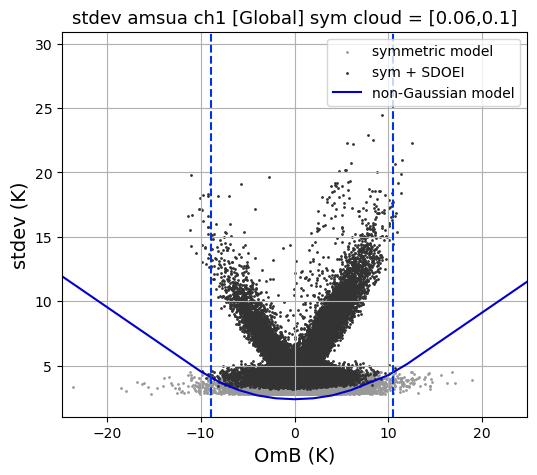

In [73]:
fig, ax = plt.subplots(figsize=(6,5))
ax.scatter(select_cloud_df['omf_ges'].iloc[plot_data],   select_cloud_df['symerr_ges'].iloc[plot_data], s=1, color=(0.6,0.6,0.6), label='symmetric model')
ax.scatter(select_cloud_df['omf_ges'].iloc[plot_data], 1/select_cloud_df['errinv_ges'].iloc[plot_data], s=1, color=(0.2,0.2,0.2), label='sym + SDOEI')
ax.plot(nginfo[2]['coarse_axis'], nginfo[2]['coarse_record_sig'], linewidth=1.5, color=(0, 0, 0.8), label='non-Gaussian model')
ax.axvline(nginfo[2]['axis_omf'][nginfo[2]['range_min_idx']], linestyle='--', color=(0, 0.2, 0.9))
ax.axvline(nginfo[2]['axis_omf'][nginfo[2]['range_max_idx']], linestyle='--', color=(0, 0.2, 0.9))
plt_range = max(np.abs(select_cloud_df['omf_ges'].iloc[plot_data]))
ax.set_xlim(-1.05*plt_range, 1.05*plt_range)
ax.set_xlabel('OmB (K)',fontsize=14)
ax.set_ylabel('stdev (K)',fontsize=14)
ax.legend(loc='best')

sym_cloud_low  = nginfo[2]['cloud_edge'][0] 
sym_cloud_high = nginfo[2]['cloud_edge'][1]
ax.set_title(f'stdev {instrument} {channel} [Global] sym cloud = [{sym_cloud_low},{sym_cloud_high}]',fontsize=13)
plt.grid(True)

In [ ]:
def inquire_nongauss_table(table_name, input_cld, input_innov):

    # first read table in:
    read_cloud_bin_next = False
    read_bias_next      = False
    read_stdev_next     = False
    ct = 0
    with open(table_name, 'r') as file:
        # Read the file line by line into a list
        lines = file.readlines()
    
        # Process each line
        for line in lines:
            # basic parameters
            if line[0:9] == 'max_range':
                max_range = float(line[17:])
            elif line[0:2] == 'dx':
                dx        = float(line[17:])
            elif line[0:9] == 'bdy_slope':
                bdy_slope = float(line[17:])
            elif line[0:13] == 'num_cloud_cat':
                num_cloud_cat = float(line[17:])
                stdev = np.zeros((int(num_cloud_cat), 2*int(max_range/dx)+1))
        
            # cloud bin
            if line[0:11] == 'cloud_bin::':
                read_cloud_bin_next = True
                continue
            
            if read_cloud_bin_next:
                cloud_bin = np.array(line.split(), dtype=np.float64)
                read_cloud_bin_next = False
        
            if line[0:6] == 'bias::':
                read_bias_next = True
                continue
            
            if read_bias_next:
                bias = np.array(line.split(), dtype=np.float64)
                read_bias_next = False
            
            if line[0:7] == 'stdev::':
                read_stdev_next = True
                continue
            
            if read_stdev_next:
                stdev[ct,:] = np.array(line.split(), dtype=np.float64)
                ct+=1
                if ct>=num_cloud_cat:
                    read_stdev_next = False
                    
    
    # then interpolate the table to get the standard deviation:
    cc = int(min(num_cloud_cat-1, np.where(input_cld - cloud_bin >= 0)[0][-1]))

    # move the innovation to 'mode relative innovation':
    input_innov = input_innov + bias[cc]
    
    # interpolate to get the stdev:
    if input_innov <= -max_range:
        output_stdev = stdev[cc,0] + bdy_slope*(-max_range - input_innov)
    elif input_innov >= max_range:
        output_stdev = stdev[cc,-1] + bdy_slope*(input_innov - max_range)
    else:
        output_stdev = np.interp(input_innov, np.arange(-max_range, max_range+dx, dx), stdev[cc,:] )

    return output_stdev


In [ ]:
# retrieve the stdev from Table for selected samples (it takes long to run this block)
table_err = np.zeros(len(select_cloud_df))
for i in range(len(select_cloud_df)):
    #table_err[i] = inquire_nongauss_table('/home/Chih-Chi.Hu/python_codes/non_Gaussian_amsua_ch1_OmF_sym_cld_qc_00_03.txt', cloud_use[i], omf_use[i])
    table_err[i] = inquire_nongauss_table(f'/home/Chih-Chi.Hu/python_codes/tables/text_files/non_Gaussian_{instrument}_{channel}_OmF_sym_cld_qc_00_03.txt', \
                      0.5*(select_cloud_df['clw_obs'].iloc[i]+select_cloud_df['clw_bg_ges'].iloc[i]), select_cloud_df['omf_ges'].iloc[i])

In [ ]:
plt.scatter(select_cloud_df['clw_obs']-select_cloud_df['clw_bg_ges'],   select_cloud_df['symerr_ges'], s=1, color=(0.6,0.6,0.6))
plt.scatter(select_cloud_df['clw_obs']-select_cloud_df['clw_bg_ges'], 1/select_cloud_df['errinv_ges'], s=1, color=(0.2,0.2,0.2))
plt.scatter(select_cloud_df['clw_obs']-select_cloud_df['clw_bg_ges'],   table_err, s=1, color=(0,0,1))
#plt.plot(nginfo[2]['coarse_axis'], nginfo[2]['coarse_record_sig'], linewidth=1.5, color=(0, 0, 0.8))
#plt.axvline(nginfo[2]['axis_omf'][nginfo[2]['range_min_idx']], linestyle='--', color=(0, 0.2, 0.9))
#plt.axvline(nginfo[2]['axis_omf'][nginfo[2]['range_max_idx']], linestyle='--', color=(0, 0.2, 0.9))
plt.grid(True)

In [75]:
len(nginfo)

9

In [ ]:
err_params_old = np.array([0.05, 0.60, 2.50, 20.00]) # clear cloud, cloudy cloud, clear stdev, cloudy stdev
err_params_new = np.array([0.03, 0.35, 2.30,  7.50])

In [ ]:
nginfo

In [ ]:
nginfo[i]['axis_omf'][nginfo[i]['range_min_idx']]

In [ ]:
nginfo[i]['recon_cost'][nginfo[i]['range_min_idx']]

In [ ]:
aa=[1,2,3]
print(aa[1:1+1])

In [62]:
min(5,3)

3